# Landsat 8 image classification with Random Forest 

## About the project

The Landsat 8 image is taken over Toledo, Ohio, USA area and the image consists of clouds above some areas of the image. [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) is a tree based classifier which is frequently used in Machine Learning studies. The satellite image is downloaded from [USGS Earth Explorer](https://earthexplorer.usgs.gov/) and the raw image consists with errors of reflected energy values due to the atmospheric column between earth surface and the satellite sensor. Therefore, the image is atmospherically corrected using Dark Object Subtraction (DOS) method of open-source [QGIS](https://www.qgis.org/en/site/) (Quantum Geographic Information System) software. It is important to perform the project with free and open-source tools, because anyone can repeat the workflow without a cost.

Parameter optimization and feature importance methods used in the project are important characteristics of the project. [Parameter optimization](https://scikit-learn.org/stable/modules/grid_search.html) is used to find the parameters of the best model. Feature importance is a method to identify the order of importance of features to classify the image into the classes accurately. 

The satellite image subset consists of a considerable amount of clouds over the land area. Cloud cover is a frequent challenge that geospatial scientists face during satellite imagery processing. It is important to observe how much the classification is affected by the cloud cover and the shades of clouds on the earth's surface. 

## Import libraries necessary for the project

The workflow utilized Numpy, Pandas, Rasterio, Geopandas, Shapely, Scikit-learn, Seaborn, Matplotlib, and Earthpy. All the necessary libraries are installed into a separate Miniconda environment and the installation instructions can be found in the documentation of each library.

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import geopandas as gpd
import rasterio as ras
from rasterio.mask import mask
from shapely.geometry import mapping

## Import satellite image

Landsat 8 imagery consists of 11 bands with multiple spatial resolutions ranging from [15 m to 100 m](https://courses.analyticsvidhya.com/courses/take/creating-time-series-forecast-using-python/texts/6132947-introduction-to-the-course). The study used only the bands with 30 m spatial resolution. After atmospheric correction, the following bands are imported for the study.

band 2- Blue,
band 3- Green,
band 4- Red,
band 5- Near Infrared (NIR),
band 6- Shortwave Infrared 1 (SWIR 1),
band 7- Shortwave Infrared 2 (SWIR 2).

Import the subset of the Landsat 8 image as a TIF file. As the image is already atmospherically corrected, the pixel values are already in the range from 0 to 1. Then convert the image to a multidimensional numpy array which could be processed with Scikit-learn tools. Import the training data for the classificaiton as a shapefile. 

It is important to collect training and testing data in the field for an accurate study. For this project, I selected points of each class by comparing them with high-resolution Google Earth Imagery. All the training, validation, and testing point samples consist of one pixel. 

In [2]:
# import satellite image subset
toledo = ras.open('L8_subset.tif')

In [3]:
# convert image to an ndarray
array = toledo.read()

# shape of ndarray
array.shape

(6, 1000, 1000)

In [4]:
# number of missing values and range of the array
print('Number of missing values:', pd.isnull(array).sum())
print('min:', np.min(array), 'maximum:', np.max(array))

Number of missing values: 0
min: 0.003685372 maximum: 1.0


There is no missing values in the pixels of the image converted to an array. Minimum and maximum values of the array are between 0.0 and 1.0.

In [5]:
# import testing and training ROIs (each point consist with only one single)
gdf = gpd.read_file('all_points.shp', header=True)
gdf.tail(4)

,CLASS_NAME,CLASS_ID,CLASS_CLRS,geometry
316,clouds,4,"0,255,0","POLYGON ((311145 4603875, 311145 4603845, 3111..."
317,clouds,4,"0,255,0","POLYGON ((309885 4602855, 309885 4602825, 3098..."
318,clouds,4,"0,255,0","POLYGON ((302925 4602795, 302925 4602765, 3028..."
319,clouds,4,"0,255,0","POLYGON ((298095 4600485, 298095 4600455, 2980..."


## Training features and labels (as X and y)

Assign all the bands of the image as the training feature for the classification. Extract the pixel values of all six bands of each training point using a shapely geometry object. 

In [6]:
# shape of the geometry column
print('Shape of the geometry column:', gdf['geometry'].shape)

Shape of the geometry column: (320,)


In [7]:
# extract geometry values of the each point using apply function
gdf.geometry.apply(print)

POLYGON ((294015 4628595, 294015 4628565, 293985 4628565, 293985 4628595, 294015 4628595))
POLYGON ((294045 4628235, 294045 4628205, 294015 4628205, 294015 4628235, 294045 4628235))
POLYGON ((292665 4628115, 292665 4628085, 292635 4628085, 292635 4628115, 292665 4628115))
POLYGON ((298515 4627965, 298515 4627935, 298485 4627935, 298485 4627965, 298515 4627965))
POLYGON ((293745 4627785, 293745 4627755, 293715 4627755, 293715 4627785, 293745 4627785))
POLYGON ((301125 4627575, 301125 4627545, 301095 4627545, 301095 4627575, 301125 4627575))
POLYGON ((288975 4627455, 288975 4627425, 288945 4627425, 288945 4627455, 288975 4627455))
POLYGON ((296235 4627215, 296235 4627185, 296205 4627185, 296205 4627215, 296235 4627215))
POLYGON ((306795 4627065, 306795 4627035, 306765 4627035, 306765 4627065, 306795 4627065))
POLYGON ((300015 4626825, 300015 4626795, 299985 4626795, 299985 4626825, 300015 4626825))
POLYGON ((310425 4626735, 310425 4626705, 310395 4626705, 310395 4626735, 310425 4626735))

0      None
1      None
2      None
3      None
4      None
       ... 
315    None
316    None
317    None
318    None
319    None
Name: geometry, Length: 320, dtype: object

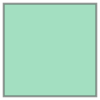

In [8]:
# generate a list of shapely geometries
geoms = gdf.geometry.values

# check a single shapely geometry from the list above
geometry = geoms[0] 
geometry

In [9]:
# shape of the geoms 
print('Shape of geoms list:', geoms.shape)

Shape of geoms list: (320,)


In [10]:
# define a function to extract all six pixel values for one pixel in the 'gdf'
def get_X (src, feature):
    out_image, out_transform = mask(src, feature, crop=True) 
    out_image_reshaped = out_image.reshape(-1, src.count)
    return out_image_reshaped[0]

In [11]:
# extract all pixel values corresponding to the points in 'gpd' from the satellite image
X_arr = gdf.geometry.apply(lambda x: get_X(toledo,[mapping(x)]))
print('Shape of X_arr:', X_arr.shape)

Shape of X_arr: (320,)


In [12]:
# create a dataframe separating the extracted pixel values for each band and list the values in for each data point 
X=pd.DataFrame(X_arr.values.tolist())
X

,0,1,2,3,4,5
0,0.034938,0.039970,0.034199,0.580108,0.193642,0.080030
1,0.035258,0.042979,0.036542,0.551938,0.202621,0.086468
2,0.547329,0.589020,0.663411,0.836770,0.690327,0.553808
3,0.041647,0.061232,0.047568,0.032151,0.013823,0.012319
4,0.034321,0.042831,0.035087,0.551864,0.194555,0.080844
...,...,...,...,...,...,...
315,0.034198,0.033778,0.031115,0.179167,0.053586,0.026256
316,0.436183,0.479279,0.540592,0.796464,0.678315,0.553463
317,0.533565,0.559223,0.631664,0.837806,0.577848,0.447173
318,0.540694,0.569041,0.635068,0.792320,0.625208,0.490809


In [13]:
# shape of the X array (features)
print('Shape of X features:', X.shape)

Shape of X features: (320, 6)


In [14]:
# convert X dataframe to a numpy array
X = X.values
X

array([[0.03493756, 0.03996976, 0.03419858, 0.58010787, 0.19364224,
        0.08002957],
       [0.03525822, 0.04297906, 0.03654197, 0.55193788, 0.20262083,
        0.08646768],
       [0.54732913, 0.58902043, 0.66341078, 0.83676982, 0.69032723,
        0.55380833],
       ...,
       [0.5335654 , 0.55922341, 0.63166404, 0.83780587, 0.5778479 ,
        0.447173  ],
       [0.540694  , 0.56904066, 0.63506806, 0.7923196 , 0.62520766,
        0.49080887],
       [0.48901814, 0.51692045, 0.58314353, 0.78760803, 0.70169848,
        0.59071016]])

## Labels for classification

Select the values of CLASS_ID column of 'gdf' as y (training labels) for the classification. Take the values as 'float64' numbers to use in classification algorithm.

'Class ID' values for each class are as below.
- 1: Water 
- 2: Vegetation 
- 3: Buildings 
- 4: Clouds 

In [15]:
# # create train labels
y1= gdf.CLASS_ID.astype('float64')
y=np.asarray(y1)
y

array([2., 2., 4., 1., 2., 1., 4., 2., 1., 1., 1., 4., 4., 1., 1., 1., 4.,
       4., 2., 2., 2., 1., 1., 1., 1., 1., 2., 1., 1., 3., 1., 3., 1., 2.,
       3., 1., 1., 4., 3., 4., 3., 1., 1., 1., 2., 1., 2., 3., 2., 1., 1.,
       3., 1., 3., 1., 3., 3., 1., 1., 3., 2., 3., 3., 2., 1., 3., 1., 2.,
       3., 3., 2., 2., 1., 2., 2., 2., 3., 1., 3., 3., 1., 3., 2., 2., 1.,
       2., 3., 2., 2., 2., 3., 2., 1., 3., 2., 2., 3., 1., 3., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 3., 2., 3., 3., 3., 3., 1., 3., 1., 1.,
       3., 3., 3., 3., 3., 4., 4., 4., 4., 4., 4., 4., 3., 3., 4., 4., 4.,
       3., 4., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 1., 1., 1., 4., 1., 4., 4., 1., 4., 4.,
       3., 3., 1., 3., 4., 1., 3., 3., 1., 4., 3., 3., 1., 4., 1., 1., 3.,
       3., 2., 1., 1., 1., 1., 3., 1., 3., 1., 3., 3., 3., 3., 3., 2., 1.,
       2., 2., 4., 2., 3., 3., 3., 3., 2., 2., 1., 2., 4., 2., 4., 2., 2.,
       4., 1., 2., 4., 2.

In [16]:
# shape of the y array (labels)
print('Shape of y labels:', y.shape)

Shape of y labels: (320,)


## Divide ROIs for training, validation, and testing data

Training: testing ratio is kept as for 2: 1 or 3: 2 in a typical machine learning project. Divide the extracted data points for training, validation, and testing to the ratio 2: 1: 1, respectively.  

First, divide testing and training data to two equal sets, then keep one group as training data. Divide the other group into two similar sets as validation and testing data.

In [17]:
# import function and divide ROIs to 2 equal sets 
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=2, random_state = 42)
skf.get_n_splits(X, y)

2

In [18]:
# stratified k-fold function
skf

StratifiedKFold(n_splits=2, random_state=42, shuffle=False)

In [19]:
# number of samples assigned for training set and the remain
for train_index, remain_index in skf.split(X, y):
    print('Train:', len(train_index), 'Remain:', len(remain_index))
    # assigned the divided data to training and remaining variable with similar number of samples of each class
    X_train, X_remain = X[train_index], X[remain_index]
    y_train, y_remain = y[train_index], y[remain_index]

Train: 160 Remain: 160
Train: 160 Remain: 160


In [20]:
# shape of training features
print('Shape of the training features:', X_train.shape)

Shape of the training features: (160, 6)


In [21]:
# lengths of validation and testing data
for val_index, test_index in skf.split(X_remain, y_remain):
    print('validation:', len(val_index), 'test:', len(test_index))

validation: 80 test: 80
validation: 80 test: 80


In [22]:
# split remaining features and label into validation and test sets consist with similar samples of each class
for test_index, val_index in skf.split(X_remain, y_remain):
    X_val, X_test = X_remain[val_index], X_remain[test_index]
    y_val, y_test = y_remain[val_index], y_remain[test_index]

In [23]:
# shape of the validation features
print('shape of the validation features:', X_val.shape)

shape of the validation features: (80, 6)


## Import and fit Random Forest classifier

Random Forest creates and fits multiple decision tree classifiers utilizing several subsets of training samples and average the results. As a consequence, Random Forest controls overfitting the algorithm to training data. 


In [24]:
# import the classifier
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier()

In [25]:
# fit classifier to training data
rf= clf.fit(X_train, y_train)

C:\Users\tha87\Miniconda3\envs\deepgeo\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


## Hyperparameter tuning with with Randomized search 
Model selection techniques are used in Machine Learning studies to find the models with the highest accuracy. Hyperparameter tuning is one frequently used method in model selection. 

Randomized search is used in this project during training the model to find the best parameters (settings) to be used for the subsequent classification.

Define lists of parameter values to be assessed with randomized search method. Random combinations of the parameters will be assigned to the classifier during randomized search. It is worth to explore the difference between [Randomized Search and Grid Search](https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html). 

In [26]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
classifier__n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
#max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
classifier__max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
classifier__max_depth.append(None)
# Minimum number of samples required to split a node
classifier__min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
classifier__min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
classifier__bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': classifier__n_estimators,
               #'max_features': max_features,
               'max_depth': classifier__max_depth,
               'min_samples_split': classifier__min_samples_split,
               'min_samples_leaf': classifier__min_samples_leaf,
               'bootstrap': classifier__bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [27]:
# Use the random grid to search for best hyperparameters, using 4 fold cross validation
# search across 100 different combinations, use all available cores

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 100, cv= 4, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_val, y_val)

Fitting 4 folds for each of 100 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   47.2s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  2.1min finished


RandomizedSearchCV(cv=4, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators=10,
                                                    n_jobs=None,
  

## Train and Test the classifier with best parameters

Find the best parameters returned from the randomized search and fit it with the training data. Testing accuracy can be found with the testing features and labels.

In [28]:
# return the best set of parameters
print('Best parameters:',rf_random.best_params_)

Best parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 80, 'bootstrap': False}


In [29]:
# return the highest classification accuracy
print('Best classification score:',rf_random.best_score_)

Best classification score: 0.9125


In [30]:
# assign the best parameters returned from gridsearch and fit algorithm to training data
classifier_best = RandomForestClassifier(**rf_random.best_params_)
classifier_best.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=80, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [31]:
# testing accuracy 
('Best testing score:',classifier_best.score(X_test,y_test))

('Best testing score:', 0.8875)

The close values of validation and test accuracies (0.91 and 0.90 respectively) implies that the classifier does not overfit with the training or validation data.

## Confusion Matrix

Confusion matrix is a measure of the [quality of the classification output](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html). Confusion matrix is produced by assessing the predicted classes against true classes of the pixels using a table. The confusion matrix below is created with actual and predicted classes of testing data. The diagonal values of the confusion matrix represent the pixels classified into the correct classes. Pixels represent the cells other than diagonal values indicate the misclassified pixels (false positive and false negative). 

In [32]:
# predict testing y values with the best classifier
y_predicted= classifier_best.predict(X_test)

In [33]:
# create confusion matrix with testing and predicted values
from sklearn.metrics import confusion_matrix
cm= confusion_matrix(y_test,y_predicted)
cm

array([[20,  0,  0,  0],
       [ 4, 16,  0,  0],
       [ 0,  0, 18,  2],
       [ 0,  0,  3, 17]], dtype=int64)

Text(69.0, 0.5, 'True')

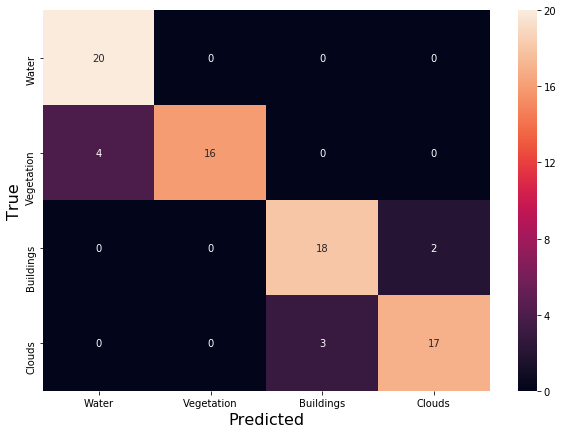

In [34]:
# plot confusion matrix
import seaborn as sns
plt.figure(figsize= (10,7))
sns.heatmap(cm, xticklabels= ['Water','Vegetation','Buildings','Clouds'], yticklabels= ['Water','Vegetation','Buildings','Clouds'],annot=True)
plt.xlabel('Predicted',fontsize=16)
plt.ylabel('True',fontsize=16)

According to the confusion matrix, four pixels are predicted as 'Water' while the true class is 'Vegetation'. These misclassifications reduce the classification accuracy.

## Feature importance for the classification

The image consists of 6 bands which are the features of the classification. Feature importance tool returns the order of importance of features for the particular classification. Feature importance is returned as a numerical value and let's visualize the feature importance in a graph. 

In [35]:
#import libraries
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

In [36]:
# assign the feature importance to a variable
importances = classifier_best.feature_importances_

Feature ranking:
1. feature 0 (0.254308)
2. feature 2 (0.188479)
3. feature 3 (0.177045)
4. feature 5 (0.134381)
5. feature 1 (0.129357)
6. feature 4 (0.116430)


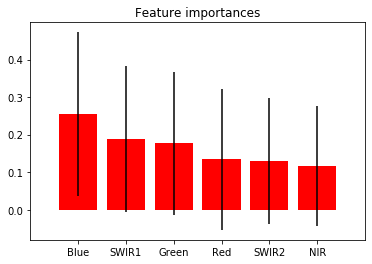

In [37]:
# plot the feature importance in a graph
# calculate the standard deviation of each feature to plot with the bars
indices = np.argsort(importances)[::-1]
std = np.std([tree.feature_importances_ for tree in classifier_best.estimators_],
               axis=0)

# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xticks(indices, ('Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2'))
plt.xlim([-1, X.shape[1]])
plt.show()

According to the feature importance results, blue band has the highest importance to classify the image and SWIR1 has the least importance. The important output of the feature importance is that a similar accuracy could be reached if we use only the most important bands in classification. It is important to remind that the order of the feature importance may differ if the accuracy of the classification changed by adjusting the parameters of the algorithm.  

## Classify the image using with optimum classification algorithm

First, reshape the array as an image to apply the classifier. Then apply the classifier and predict the class of each pixel whether it is water, vegetation, buildings, or clouds. Then visualize both classified image and the original image to compare the classification accuracy of the image.

In [38]:
from rasterio.plot import reshape_as_raster, reshape_as_image

# reshape original image into 2d array (nrow * ncol, nband) to use in classification 
reshaped_img = reshape_as_image(array)
reshaped_img.shape

(1000, 1000, 6)

In [39]:
# predict the class of each pixel
class_prediction = classifier_best.predict(reshaped_img.reshape(-1, 6))

# Reshape the classified array back to a 2D matrix
class_prediction = class_prediction.reshape(reshaped_img[:, :, 0].shape)
class_prediction.shape

(1000, 1000)

In [40]:
# predicted array of classes
class_prediction

array([[2., 2., 2., ..., 1., 1., 1.],
       [2., 2., 2., ..., 1., 1., 1.],
       [2., 2., 2., ..., 1., 1., 1.],
       ...,
       [3., 3., 4., ..., 3., 3., 3.],
       [4., 3., 4., ..., 3., 3., 3.],
       [4., 4., 4., ..., 3., 3., 3.]])

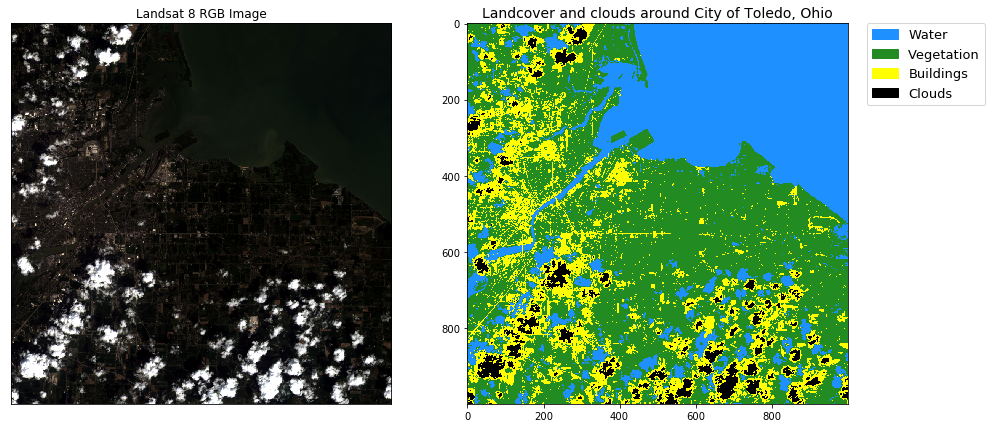

In [41]:
import earthpy.plot as ep
from matplotlib import colors

# show classified image and original image
fig, axs = plt.subplots(1,2,figsize=(15,12))
ep.plot_rgb(array, rgb=(2, 1, 0),ax=axs[0], title='Landsat 8 RGB Image',stretch=True)


# add a title and legend for the classified image
plt.title('Landcover and clouds around City of Toledo, Ohio',fontsize='14')

cmap = colors.ListedColormap([ 'dodgerblue','forestgreen','yellow','black'])
im = axs[1].imshow(class_prediction, cmap=cmap)
ep.draw_legend(im, titles=["Water", "Vegetation", "Buildings","Clouds"])
plt.show()

## Classification accuracy

Now the classification task is completed and the classified image is returned successfully with 90% accuracy. However, the classified image shows several misclassified vegetation areas into water class as a result of the shadows on the land created by the clouds. It is important to mask or replace those pixels before performing further analysis with the image.